In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
from tensorflow import keras
import joblib
import math
%config InlineBackend.figure_format='retina'
# keras random seed https://junstar92.tistory.com/98

In [2]:
train_pm = pd.read_csv('/content/drive/MyDrive/AIVLE/제5회 AI SPARK 공모전/DATA_modeling1/train_pm_dummies.csv')

In [3]:
place_lst = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
df_all = train_pm.copy()

for place in place_lst:
    globals()['df_{}'.format(place)] = df_all[df_all['측정소{}'.format(place)]==1]

timestep_input = 48
timestep_output = 72
timestep = timestep_input + timestep_output


for place in place_lst:

    df = globals()['df_{}'.format(place)]
    encoder_x = []

    for i in range( 0, len(df) - timestep_output - timestep_input): 
        encoder_x.extend([df.iloc[i : i + timestep_input, :].values])

Encoder_X = np.array(encoder_x)
print(Encoder_X.shape)


for place in place_lst:

    df = globals()['df_{}'.format(place)]
    decoder_x = []

    for i in range( 0, len(df) - timestep_output - timestep_input ):
        decoder_x.extend([df.iloc[i + timestep_input : i + timestep_input + timestep_output, 6:].values])
        
Decoder_X = np.array(decoder_x)
print(Decoder_X.shape)


for place in place_lst:

    df = globals()['df_{}'.format(place)]
    decoder_y = []

    for i in range( 0, len(df) - timestep_output - timestep_input ):
        decoder_y.extend([df.iloc[i + timestep_input : i + timestep_input + timestep_output, 0].values.T])
        
Decoder_Y = np.array(decoder_y)
print(Decoder_Y.shape)

(34944, 48, 95)
(34944, 72, 89)
(34944, 72)


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from keras import optimizers, initializers, losses

EPOCHS = 200
LEARNING_RATE = 0.0001
OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE)
INITIALIZER = initializers.HeNormal(seed=RANDOM_SEED)
LOSS = losses.MeanSquaredError()

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 batch_size: int,
                 shuffle: bool = False) -> None:
        
        self.encoder_x = Encoder_X
        self.decoder_x = Decoder_X
        self.y = Decoder_Y

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        self.index = np.arange(len(self.encoder_x))
        if self.shuffle:
            np.random.shuffle(self.index)


    def __len__(self):
        return math.ceil(len(self.encoder_x) / self.batch_size)

    def __getitem__(self, index):
        batch_index = self.index[index*self.batch_size:(index+1)*self.batch_size]

        encoder_x_batch = self.encoder_x[ [i for i in batch_index] ]

        decoder_x_batch = self.decoder_x[ [i for i in batch_index] ]

        y_batch = self.y[ [i for i in batch_index] ]

        return [encoder_x_batch,decoder_x_batch], y_batch

In [6]:
train_gen = DataGenerator(batch_size = 128, shuffle=True)

In [7]:
# Early Stopping

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss',         
                   min_delta=0.01,                
                   patience=15,                 
                   verbose=1,
                   restore_best_weights=True)  

In [8]:
# 8.43

tf.random.set_seed(RANDOM_SEED)
tf.keras.backend.clear_session()

from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed

BATCH_SIZE = None

ENCODER_INPUT_DIM = train_gen.encoder_x.shape[2]  # 11
DECODER_INPUT_DIM = train_gen.decoder_x.shape[2]  # 11

ENCODER_TIMESTEP = 48
DECODER_TIMESTEP = 72
LATENT_DIM = 256

# rnn 계열은 무조건 tanh 사용해야 gpu학습 가능.

# Encoder

encoder_inputs = Input(shape=(ENCODER_TIMESTEP, ENCODER_INPUT_DIM))

lstm_enc_0, latent_c_0, latent_h_0 = LSTM(LATENT_DIM, activation='tanh', return_sequences=True, return_state=True)(encoder_inputs)

lstm_enc, latent_c_1, latent_h_1 = LSTM(LATENT_DIM, activation='tanh', return_sequences=True, return_state=True)(lstm_enc_0)

_, latent_c_2, latent_h_2 = LSTM(LATENT_DIM, activation='tanh', return_sequences=False, return_state=True)(lstm_enc) # return_sequences = True는 timestep별 출력 , return_state = True, last_hidden_state 출력

lstm0_output = [latent_c_0, latent_h_0]
lstm1_output = [latent_c_1, latent_h_1]
lstm2_output = [latent_c_2, latent_h_2]

# Decoder

decoder_inputs = Input(shape=(DECODER_TIMESTEP, DECODER_INPUT_DIM))

lstm_dec_0 = LSTM(LATENT_DIM, activation='tanh', return_sequences=True)(decoder_inputs, initial_state=lstm0_output)

lstm_dec = LSTM(LATENT_DIM, activation='tanh', return_sequences=True)(lstm_dec_0, initial_state=lstm1_output)

step, latent_c, latent_h = LSTM(LATENT_DIM, activation='tanh', return_sequences=True, return_state=True)(lstm_dec,initial_state=lstm2_output)


# Regressor

# TimeDistributed
# https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

# regressor_outputs = TimeDistributed(Dense(512, activation='relu'))(step)

# regressor_outputs = Dense(512, activation='relu')(step) # 1,759,233
regressor_result = TimeDistributed(layer = Dense(1))(step) 

   
model = Model([encoder_inputs, decoder_inputs], regressor_result)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 95)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 72, 89)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 48, 256),    360448      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [9]:
model.compile(loss=LOSS, optimizer=OPTIMIZER)
model.fit(train_gen, epochs=5, callbacks=[es], shuffle=True)

Epoch 1/5
273/273 [==============================] - 25s 42ms/step - loss: 0.0048
Epoch 2/5
273/273 [==============================] - 12s 42ms/step - loss: 0.0044
Epoch 3/5
273/273 [==============================] - 12s 43ms/step - loss: 0.0043
Epoch 4/5
273/273 [==============================] - 12s 42ms/step - loss: 0.0042
Epoch 5/5
273/273 [==============================] - 12s 43ms/step - loss: 0.0041


In [10]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/AIVLE/제5회 AI SPARK 공모전/DATA_modeling9/model.pkl')

['/content/drive/MyDrive/AIVLE/제5회 AI SPARK 공모전/DATA_modeling9/model.pkl']

In [11]:
test_pm = pd.read_csv('/content/drive/MyDrive/AIVLE/제5회 AI SPARK 공모전/DATA_modeling1/test_pm_dummies.csv')

In [12]:
place_lst = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
df_all = test_pm.copy()

for place in place_lst:
    globals()['df_{}'.format(place)] = df_all[df_all['측정소{}'.format(place)]==1]

timestep_input = 48
timestep_output = 72
timestep = timestep_input + timestep_output

encoder_x = []
for place in place_lst:

    df = globals()['df_{}'.format(place)]

    for i in range( len(df)//(timestep_input+timestep_output)): 
        encoder_x.extend([df.iloc[i*timestep : i*timestep + timestep_input, :].values])

Encoder_X = np.array(encoder_x)
print(Encoder_X.shape)


decoder_x = []
for place in place_lst:

    df = globals()['df_{}'.format(place)]

    for i in range( len(df)//(timestep_input+timestep_output) ):
        decoder_x.extend([df.iloc[i*timestep + timestep_input : i*timestep + timestep_input + timestep_output, 6:].values])
        
Decoder_X = np.array(decoder_x).astype('float')
print(Decoder_X.shape)


decoder_y = []
for place in place_lst:

    df = globals()['df_{}'.format(place)]

    for i in range( len(df)//(timestep_input+timestep_output) ):
        decoder_y.extend([df.iloc[i*timestep + timestep_input : i*timestep + timestep_input + timestep_output, 0].values.T])
        
Decoder_Y = np.array(decoder_y)
print(Decoder_Y.shape)

(1088, 48, 95)
(1088, 72, 89)
(1088, 72)


In [13]:
test_encoder_x = Encoder_X

test_decoder_x = Decoder_X

In [14]:
y_pred = model.predict([test_encoder_x,test_decoder_x])

34/34 [==============================] - 2s 11ms/step


In [15]:
answer = pd.read_csv('/content/drive/MyDrive/AIVLE/제5회 AI SPARK 공모전/answer_sample.csv')
answer['PM2.5'] = y_pred.reshape(y_pred.shape[0]*y_pred.shape[1], 1)

In [16]:
answer.to_csv('/content/drive/MyDrive/AIVLE/제5회 AI SPARK 공모전/DATA_modeling9/answer.csv', index=False)

In [17]:
len(answer[answer['PM2.5']<0])

28354

In [18]:
answer[answer['PM2.5']<0]['측정소'].value_counts()

읍내동     3104
문창동     2460
독곶리     2309
성성동     2279
정림동     2137
대천2동    1939
이원면     1931
노은동     1922
모종동     1779
논산      1756
아름동     1342
동문동     1286
예산군     1171
신방동     1120
신흥동     1031
공주       724
홍성읍       64
Name: 측정소, dtype: int64

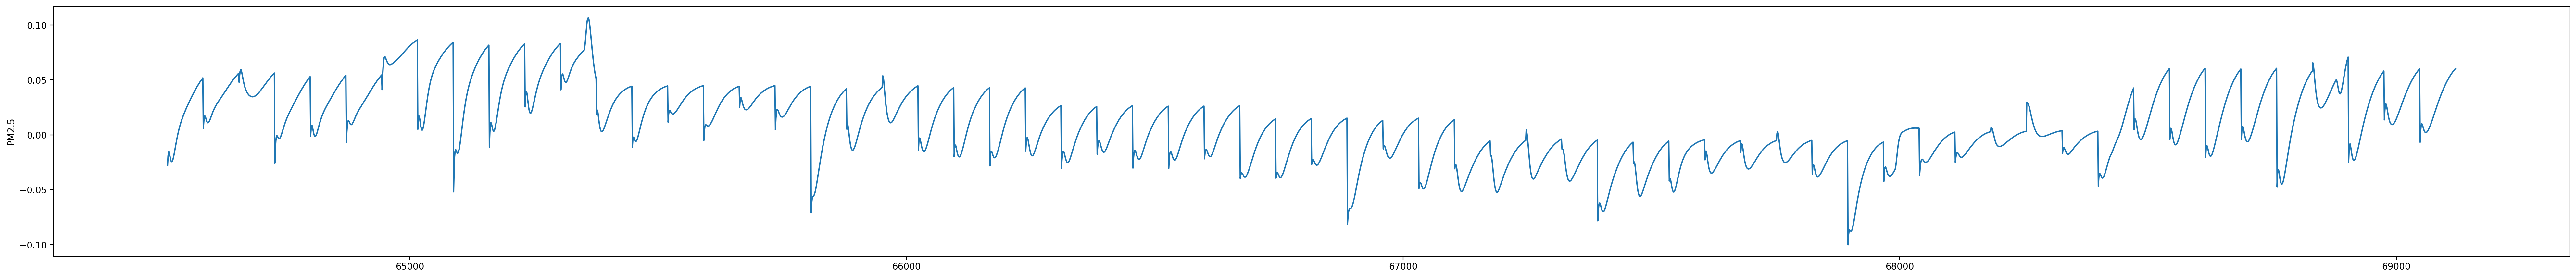

In [21]:
plt.figure(figsize=(50,5))
sns.lineplot(x=answer[answer['측정소']=='이원면'].index, y='PM2.5', data=answer[answer['측정소']=='이원면'])
plt.show()